## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

# Results

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from utils import parse_tensorboard_logs, plot_metrics

In [2]:
def get_tensorboard_dir(model_name):
    return f'runs/{model_name}'

## Baseline
Baseline model achieves ~14 BLEU on test dataset and requires approximately 3 seconds for inference (on 7500 test samples) and 70 seconds per epoch (40000 samples) for training.

## GRU encoder/decoder with attention
Model architecture is in models.py: GRU-based encoder-decoder with attention in decoder output.

This model achieves ~33.2 BLEU on test dataset and requires approximately 4 seconds for inference and 115 seconds per epoch for training.

### Beam search
Adding beam search (with beam width = 10) to this model gives best test BLEU score (~36.4), but requires 6 _minutes_ for inference (120 times slower than baseline and 90 times slower than the same model without beam search). Adding it to training procedure (for logging and model selection, _which is not required_) slows down training to 4 minutes per epoch (~3.5 times slower than baseline)

In [6]:
best_model_logs = parse_tensorboard_logs(get_tensorboard_dir('gru_attention_beam_search_2020-05-30--01-10-20'))

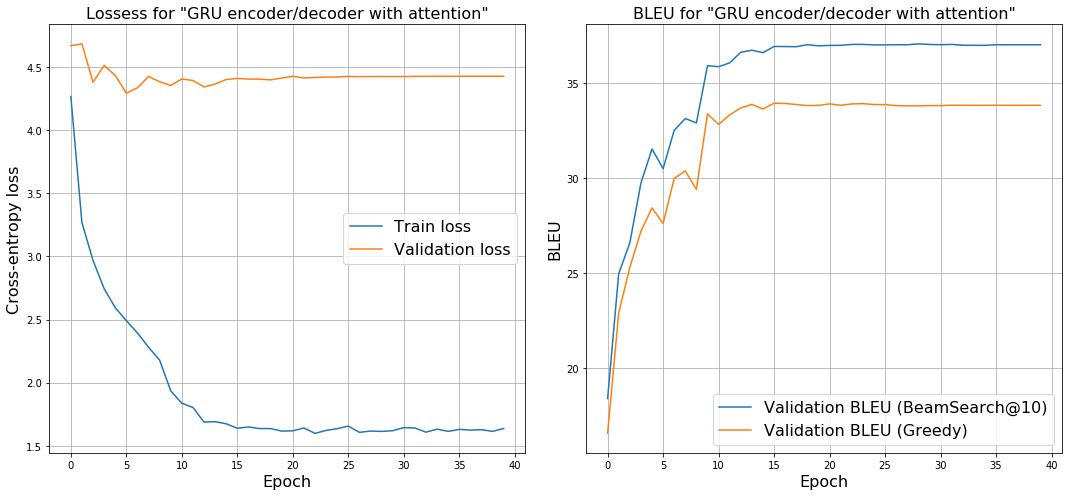

In [7]:
plot_metrics(best_model_logs, '"GRU encoder/decoder with attention"')

## Less successful experiments
### Bidirectional GRU
Bidirectionality (of encoder's GRU) hasn't improved quality of GRU encoder-decoder _with attention_. I didn't try it with baseline.

### Decay for teacher_forcing_ratio
Replacing constant $teacher\_forcing\_ratio=0.5$ with dynamically calculated as
$$teacher\_forcing\_ratio_{decay}(epoch) = 0.5 * decay^{epoch}$$
for $decay$ values $0.7, 0.95, 0.99$ has shown quite interesting results. This technique has dropped validation cross-entropy loss from ~4.4 to ~3.7. But validation/test BLEU (with greedy inference as well as with beam search) has also dramatically decreased:

In [8]:
dtf_model_logs = parse_tensorboard_logs(get_tensorboard_dir('gru_attention_beam_search_dtf_2020-05-28--20-40-09'))

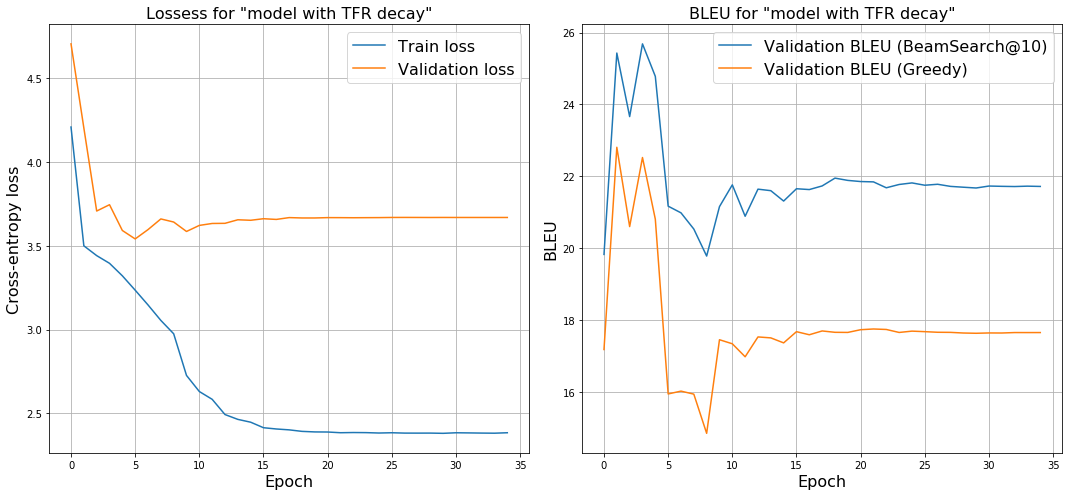

In [10]:
plot_metrics(dtf_model_logs, '"model with TFR decay"')

### Transformer
I've tried to write transformer-based model with nn.TransformerEncoder as encoder and nn.TransformerDecoder as decoder, with PositionalEncoding for both. Since transformers have complexity $O(n^2)$, I had to trim the inputs to 60 tokens and reduce the batch size to 32. It took approximately 21 min per epoch for training and gave ~19 validation BLEU after 10 epochs.